# Script 2: Modeling on Tabular Data
#### Final Project in Data Mining, Machine Learning, and Deep Learning|
#### Erik Konstenius, Theodore Balas and Muhammad Azkaenza

## Dependencies

In [1]:
# !pip install pydot pydotplus numpy pandas matplotlib seaborn xgboost sklearn tensorflow keras graphviz
# !pip install keras-tuner --upgrade

## Import Packages

In [60]:
# Library import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_tree
import graphviz

from sklearn import metrics, tree
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from keras import backend as K, regularizers
from keras.layers import Dense, Activation, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch

### Load csv files created in Script 1
#### X_train, X_valid, X_test, y_train, y_valid, y_test

In [61]:
features = ['width', 'height', 'acrylic', 'guache', 'ink', 'oil', 'pastel',
          'watercolour', 'origin_freq_encoding']

X_train = pd.read_csv("X_train.csv", usecols = features)
X_valid = pd.read_csv("X_valid.csv", usecols = features)
X_test = pd.read_csv("X_test.csv", usecols = features)
X_vt = X_valid.append(X_test)
X = X_train.append(X_vt)

y_train = pd.read_csv("y_train.csv").values
y_valid = pd.read_csv("y_valid.csv").values
y_test = pd.read_csv("y_test.csv").values
y_vt = np.append(y_valid, y_test)
y = np.append(y_train, y_vt)

In [62]:
X_train.head()

,width,height,acrylic,guache,ink,oil,pastel,watercolour,origin_freq_encoding
0,0.405906,0.558779,0.0,0.0,0.0,1.0,0.0,0.0,0.291229
1,0.787287,0.609305,0.0,0.0,0.0,1.0,0.0,0.0,0.291229
2,0.126126,0.101051,0.0,0.0,0.0,1.0,0.0,0.0,0.291229
3,0.069069,0.094547,0.0,0.0,0.0,0.0,1.0,0.0,0.291229
4,0.202202,0.253627,0.0,0.0,0.0,1.0,0.0,0.0,0.291229


In [63]:
def r_square(y_true, y_pred):
    from keras import backend
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return (1 - SS_res/(SS_tot + backend.epsilon()))

def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def coeff_determination(y_test, y_pred):
    SS_res = K.sum(K.square(y_test - y_pred))
    SS_tot = K.sum(K.square(y_test - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Price Prediction based on tabular data

## Linear Regression
Predict the price based on simple regression. And 'watercolour' is dropped to avoid dummy variable trap.

In [64]:
MLR = LinearRegression()  
MLR.fit(X_train.loc[:, X_train.columns != 'watercolour'] , y_train)

LinearRegression()

In [65]:
y_pred_MLR = MLR.predict(X_vt.loc[:, X_vt.columns != 'watercolour'])
np.save('y_pred_MLR.npy', y_pred_MLR)

In [66]:
print('R2  : ', r2_score(y_vt, y_pred_MLR))
print('MAE : ', mean_absolute_error(y_vt, y_pred_MLR))
print('MSE : ', mean_squared_error(y_vt, y_pred_MLR))
print('RMSE: ', np.sqrt(mean_squared_error(y_vt, y_pred_MLR)))

R2  :  0.5090208951585466
MAE :  0.0777718820169703
MSE :  0.014581177215998836
RMSE:  0.12075254538103466


In [67]:
MLR_coef = pd.DataFrame(data=[pd.Series(X_train.columns),pd.Series(MLR.coef_[0])]).T 
MLR_coef.columns=['Parameter','Coefficient']
dict = {'Parameter': 'intercept', 'Coefficient': MLR.intercept_[0]}
MLR_coef = MLR_coef.append(dict, ignore_index = True)
MLR_coef

# please ignore the NaN value at origin_freq_encoding
# to avoid falling falling into the dummy variable trap
# watercolour should have been removed
# NB!!! the error was made ONLY in this demo file

,Parameter,Coefficient
0,width,0.338562
1,height,0.317205
2,acrylic,0.023098
3,guache,0.009188
4,ink,0.016695
5,oil,0.063356
6,pastel,-0.007658
7,watercolour,0.063265
8,origin_freq_encoding,NaN
9,intercept,-0.073331


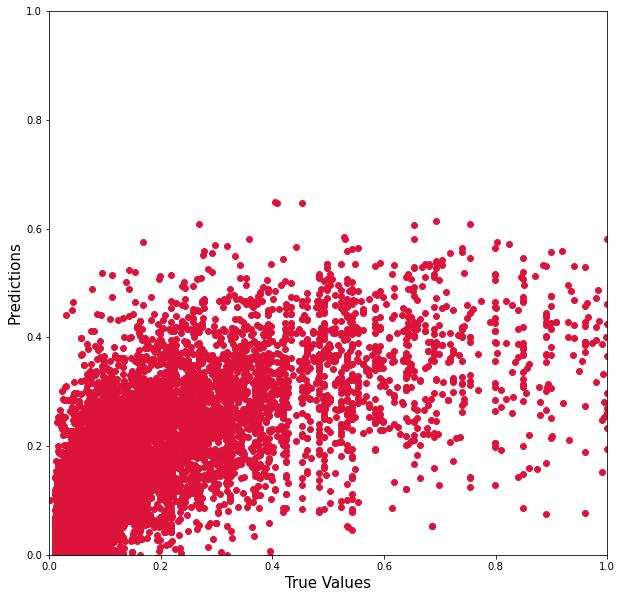

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(y_vt, y_pred_MLR, c='crimson')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

## Multilayer Perceptron (MLP)

### Initial Model of MLP

In [69]:
# simple Artificial Neural Network

# initialisation
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(16, activation = 'relu', input_shape = (9,)))
model.add(BatchNormalization())

# Adding the second hidden layer
model.add(Dense(units = 16, activation = 'relu'))
model.add(BatchNormalization())

# Adding the third hidden layer
model.add(Dense(units = 16, activation = 'relu'))
model.add(BatchNormalization())

# Adding the output layer
model.add(Dense(units = 1))

In [70]:
# optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'mean_squared_error', metrics=[r_square])

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               6

In [72]:
history = model.fit(X_train.to_numpy(), y_train, validation_data = (X_valid.to_numpy(), y_valid), batch_size=32, epochs = 50)

Epoch 1/50
1500/1500 [==============================] - 2s 804us/step - loss: 0.0410 - r_square: -0.7373 - val_loss: 0.0155 - val_r_square: 0.4142
Epoch 2/50
1500/1500 [==============================] - 1s 697us/step - loss: 0.0177 - r_square: 0.3275 - val_loss: 0.0151 - val_r_square: 0.4384
Epoch 3/50
1500/1500 [==============================] - 1s 702us/step - loss: 0.0167 - r_square: 0.3739 - val_loss: 0.0151 - val_r_square: 0.4362
Epoch 4/50
1500/1500 [==============================] - 1s 727us/step - loss: 0.0162 - r_square: 0.3966 - val_loss: 0.0148 - val_r_square: 0.4347
Epoch 5/50
1500/1500 [==============================] - 1s 712us/step - loss: 0.0160 - r_square: 0.3956 - val_loss: 0.0147 - val_r_square: 0.4688
Epoch 6/50
1500/1500 [==============================] - 1s 699us/step - loss: 0.0158 - r_square: 0.4032 - val_loss: 0.0154 - val_r_square: 0.4092
Epoch 7/50
1500/1500 [==============================] - 1s 716us/step - loss: 0.0157 - r_square: 0.4160 - val_loss: 0.0148 

In [73]:
y_pred_MLP1 = model.predict(X_test)
np.save('y_pred_MLP1.npy', y_pred_MLP1)

188/188 [==============================] - 0s 423us/step


In [74]:
print('R2  : ', r2_score(y_test, y_pred_MLP1))
print('MAE : ', mean_absolute_error(y_test, y_pred_MLP1))
print('MSE : ', mean_squared_error(y_test, y_pred_MLP1))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_MLP1)))

R2  :  0.5260789521072013
MAE :  0.07531761122422403
MSE :  0.014330018273709813
RMSE:  0.11970805433933764


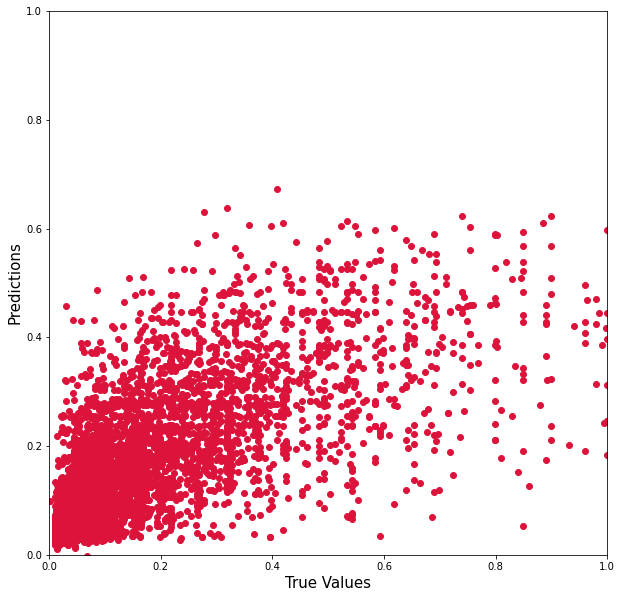

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_MLP1, c='crimson')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

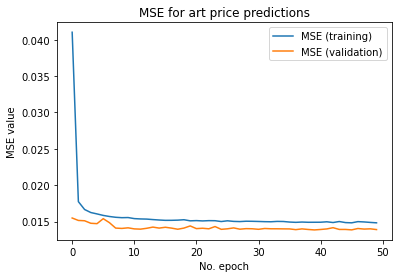

In [78]:
plt.plot(history.history['loss'], label='MSE (training)')
plt.plot(history.history['val_loss'], label='MSE (validation)')
plt.title('MSE for art price predictions')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

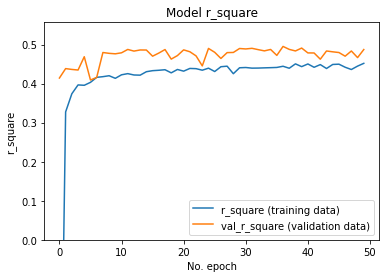

In [79]:
plt.plot(history.history['r_square'], label='r_square (training data)')
plt.plot(history.history['val_r_square'], label='val_r_square (validation data)')
plt.title('Model r_square')
plt.ylim(0,)
plt.ylabel('r_square')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

### Optimizer - Hyperparameter Tune with RandomSearch

In [31]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 8)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                     min_value=32,
                                     max_value=512,
                                     step=64),
                        activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer = Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss = 'mse',
                  metrics = ['mse', r_square])
    return model

In [32]:
# random search to find ""
tuner = RandomSearch(
    build_model,
    objective = 'val_mse',
    max_trials = 10,
    executions_per_trial = 3,
    project_name = 'Art_Price_Prediction')
 
tuner.search(X_train.to_numpy(), y_train, batch_size=64, epochs=20, validation_data=(X_valid, y_valid))

Trial 10 Complete [00h 01m 41s]
val_mse: 0.013793057451645533

Best val_mse So Far: 0.013767334011693796
Total elapsed time: 00h 27m 43s
INFO:tensorflow:Oracle triggered exit


### Optimized Model for MLP

In [80]:
# Initialising the ANN
model2 = Sequential()

model2.add(Dense(64, activation = 'relu', input_shape = (9,)))
model2.add(Dense(units = 128, activation = 'relu'))
model2.add(Dense(units = 352, activation = 'relu'))
model2.add(Dense(units = 256, activation = 'relu'))
model2.add(Dense(units = 480, activation = 'relu'))
model2.add(Dense(units = 352, activation = 'relu'))
model2.add(Dense(units = 416, activation = 'relu'))
model2.add(Dense(units = 256, activation = 'relu'))
model2.add(Dense(units = 480, activation = 'relu'))
model2.add(Dense(units = 1))

model2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[r_square, 'mse'])
history2 = model2.fit(X_train.to_numpy(), y_train, validation_data = (X_valid.to_numpy(), y_valid), batch_size = 32, epochs = 50)

Epoch 1/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0156 - r_square: 0.4343 - mse: 0.0156 - val_loss: 0.0142 - val_r_square: 0.4823 - val_mse: 0.0142
Epoch 2/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0150 - r_square: 0.4544 - mse: 0.0150 - val_loss: 0.0144 - val_r_square: 0.4433 - val_mse: 0.0144
Epoch 3/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0147 - r_square: 0.4632 - mse: 0.0147 - val_loss: 0.0144 - val_r_square: 0.4824 - val_mse: 0.0144
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0146 - r_square: 0.4645 - mse: 0.0146 - val_loss: 0.0144 - val_r_square: 0.4505 - val_mse: 0.0144
Epoch 5/50
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0146 - r_square: 0.4652 - mse: 0.0146 - val_loss: 0.0140 - val_r_square: 0.4892 - val_mse: 0.0140
Epoch 6/50
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0145 - r_square: 0.4704 - mse: 0.0145 - va

In [81]:
y_pred_MLP2 = model2.predict(X_test)
np.save('y_pred_MLP2.npy', y_pred_MLP2)

188/188 [==============================] - 0s 1ms/step


In [82]:
print('R2  : ', r2_score(y_test, y_pred_MLP2))
print('MAE : ', mean_absolute_error(y_test, y_pred_MLP2))
print('MSE : ', mean_squared_error(y_test, y_pred_MLP2))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_MLP2)))

R2  :  0.5291069045265309
MAE :  0.07469659779331034
MSE :  0.0142384616448286
RMSE:  0.11932502522450435


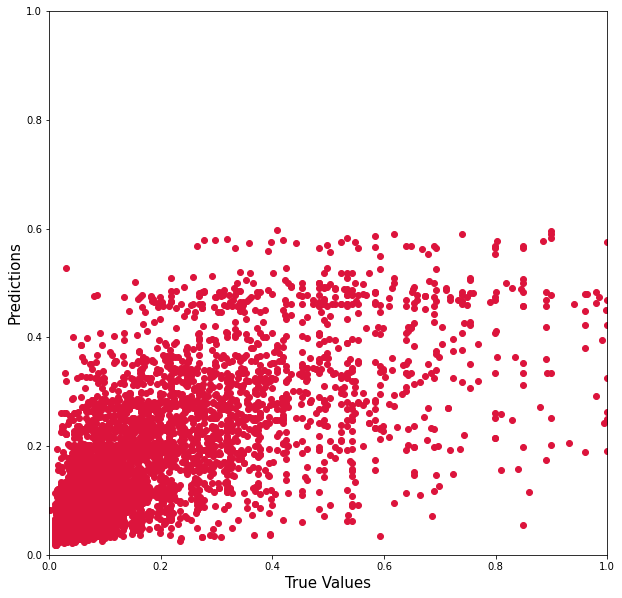

In [83]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_MLP2, c='crimson')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

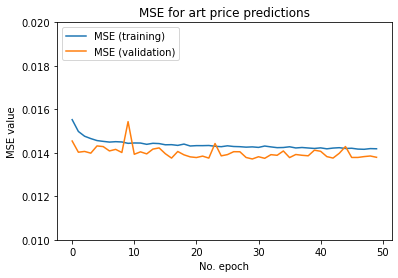

In [47]:
plt.plot(history2.history['loss'], label='MSE (training)')
plt.plot(history2.history['val_loss'], label='MSE (validation)')
plt.ylim(0.01,0.02)
plt.title('MSE for art price predictions')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

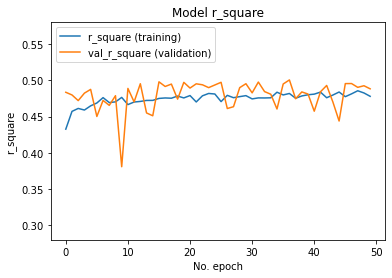

In [48]:
plt.plot(history2.history['r_square'], label='r_square (training)')
plt.plot(history2.history['val_r_square'], label='val_r_square (validation)')
plt.ylim(0.28,0.58)
plt.title('Model r_square')
plt.ylabel('r_square')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# XGBoost

We will create three XGBoost regressor and compare their results. First, we train a model with the default parameters. Second, we train a model using grid search. Third, we train a model using a custom built methodical hyperparameter tuning. The model that performs the best will be the model we will compare to other models in the paper. 

In [5]:
data_dmatrix_train = xgb.DMatrix(X_train, label = y_train)
data_dmatrix_valid = xgb.DMatrix(X_valid, label = y_valid)
data_dmatrix_test = xgb.DMatrix(X_test, label = y_test)

### XGB 1: No tuning

In [8]:
# default XGB

# those are the default parameters when XGBRegressor() is run
# the only difference being the different objective
params_init = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror'}

xg_model_1 = xgb.train(params_init, data_dmatrix_train)
y_pred_xg_model_1 = xg_model_1.predict(data_dmatrix_test)

In [9]:
print('Default XGBoost')
print('R2  : ', r2_score(y_test, y_pred_xg_model_1))
print('MAE : ', mean_absolute_error(y_test, y_pred_xg_model_1))
print('MSE : ', mean_squared_error(y_test, y_pred_xg_model_1))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_xg_model_1)))

Default XGBoost
R2  :  0.5419339156047166
MAE :  0.07680680014307899
MSE :  0.013850609482607145
RMSE:  0.11768861237438032


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

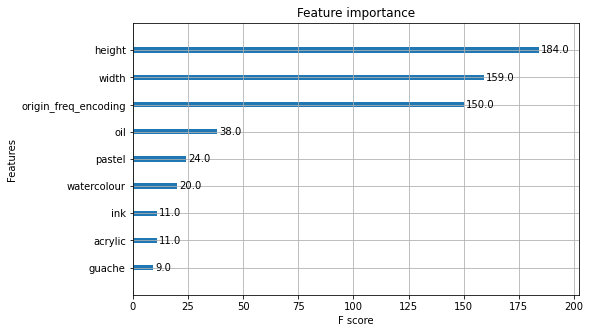

In [15]:
plt.figure(figsize=(8,5))
xgb.plot_importance(xg_model_1, ax=plt.gca())

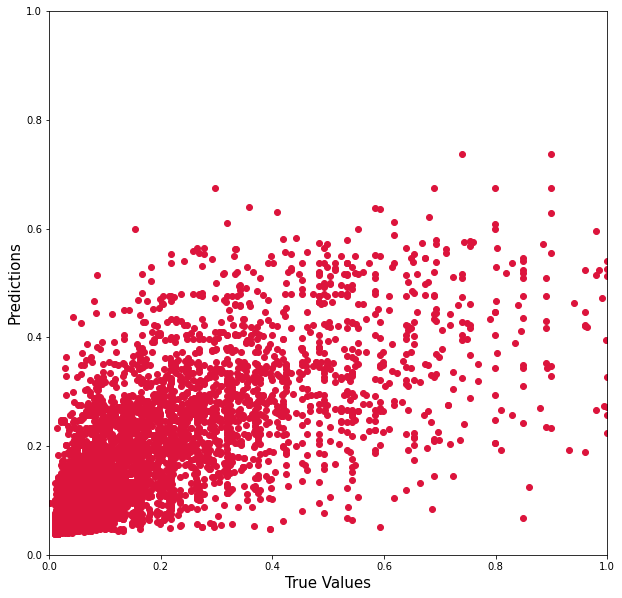

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_xg_model_1, c='crimson')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

### XGB model 2: Random Search XGB Optimiser

In [16]:
# to create this XGB model, we will be running a grid search 
# of the most significant parameters that with values that seem
# reasonable with regards to our dataset

clf = xgb.XGBRegressor() 
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
     "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [1, 3, 5, 7],
     "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
     "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs = 4,
                    scoring = 'neg_mean_squared_error',
                    cv=3)

grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    val

In [17]:
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_)
print('\n Best parameters:')
print(grid.best_params_)


 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             eta=0.1, gamma=0.4, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=12, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

 Best score:
-0.01394774569757002

 Best parameters:
{'colsample_bytree': 0.7, 'eta': 0.1, 'gamma': 0.4, 'max_depth': 12, 'min_child_weight': 3}


In [18]:
# optimised XGB
params_gs = {
    'max_depth': 12,
    'min_child_weight': 3,
    'eta':.1,
    'gamma': 0.4,
    'colsample_bytree': 0.7,
    'objective':'reg:squarederror',
}

xg_model_gs = xgb.train(params_gs, data_dmatrix_train, num_boost_round=132)
y_pred_xg_model_gs = xg_model_gs.predict(data_dmatrix_test)

In [19]:
print('Optimized XGBoost')
print('R2  : ', r2_score(y_test, y_pred_xg_model_gs))
print('MAE : ', mean_absolute_error(y_test, y_pred_xg_model_gs))
print('MSE : ', mean_squared_error(y_test, y_pred_xg_model_gs))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_xg_model_gs)))

Optimized XGBoost
R2  :  0.5516111500201621
MAE :  0.07254428324354618
MSE :  0.013557997566278677
RMSE:  0.11643881468942681


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

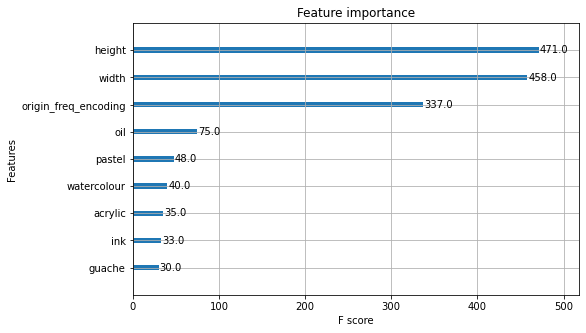

In [20]:
plt.figure(figsize=(8,5))
xgb.plot_importance(xg_model_gs, ax=plt.gca())

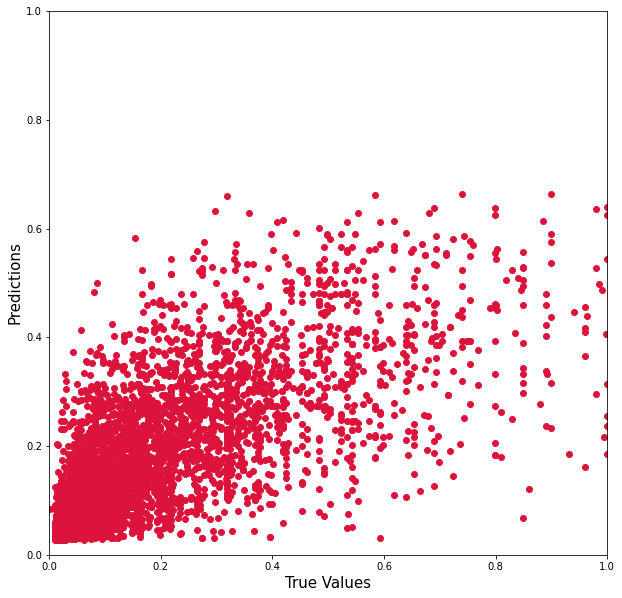

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_xg_model_gs, c='crimson')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

### XGB model 3: Methodical XBG Optimiser

In [36]:
# In this model we will be dealing with the problem of
# defining the optimal parameters, more methodically.
# When those are calculated, they will be added to the
#  aram dictionary like the eval_metric.

params['eval_metric'] = "rmse"
num_boost_round = 999

In [23]:
# This parameter (not part of the dictionary) is called num_boost_round and corresponds
# to the number of boosting rounds.
# Its optimal value highly depends on the other parameters, and thus it should be re-tuned
# each time we update a parameter.
# This could be done by tuning it together with all parameters
# in a grid-search, but it requires a lot of computational effort.

model_x = xgb.train(
    params,
    data_dmatrix_train,
    num_boost_round=num_boost_round,
    evals=[(data_dmatrix_valid, "Valid")],
    early_stopping_rounds=10
)

print("Best rmse: {:.2f} with {} rounds".format(
                 model_x.best_score,
                 model_x.best_iteration+1))

[0]	Valid-rmse:0.28706
[1]	Valid-rmse:0.21831
[2]	Valid-rmse:0.17460
[3]	Valid-rmse:0.14819
[4]	Valid-rmse:0.13303
[5]	Valid-rmse:0.12462
[6]	Valid-rmse:0.12020
[7]	Valid-rmse:0.11768
[8]	Valid-rmse:0.11629
[9]	Valid-rmse:0.11556
[10]	Valid-rmse:0.11519
[11]	Valid-rmse:0.11489
[12]	Valid-rmse:0.11464
[13]	Valid-rmse:0.11458
[14]	Valid-rmse:0.11449
[15]	Valid-rmse:0.11447
[16]	Valid-rmse:0.11440
[17]	Valid-rmse:0.11420
[18]	Valid-rmse:0.11413
[19]	Valid-rmse:0.11412
[20]	Valid-rmse:0.11407
[21]	Valid-rmse:0.11412
[22]	Valid-rmse:0.11414
[23]	Valid-rmse:0.11417
[24]	Valid-rmse:0.11405
[25]	Valid-rmse:0.11409
[26]	Valid-rmse:0.11404
[27]	Valid-rmse:0.11399
[28]	Valid-rmse:0.11389
[29]	Valid-rmse:0.11393
[30]	Valid-rmse:0.11391
[31]	Valid-rmse:0.11385
[32]	Valid-rmse:0.11366
[33]	Valid-rmse:0.11371
[34]	Valid-rmse:0.11367
[35]	Valid-rmse:0.11371
[36]	Valid-rmse:0.11368
[37]	Valid-rmse:0.11359
[38]	Valid-rmse:0.11362
[39]	Valid-rmse:0.11366
[40]	Valid-rmse:0.11373
[41]	Valid-rmse:0.11375
[4

In [24]:
# In order to tune the other hyperparameters, we will use the cv function from XGBoost.
# It allows us to run cross-validation on our training dataset and returns a RMSE score.
# An example of its functionality:

cv_results = xgb.cv(
    params,
    data_dmatrix_train,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.285306,0.000121,0.285532,0.000530
1,0.216930,0.000243,0.217427,0.000825
2,0.173468,0.000351,0.174391,0.001195
3,0.147260,0.000469,0.148624,0.001618
4,0.132188,0.000517,0.134010,0.001911
5,0.123884,0.000618,0.126110,0.002164
6,0.119294,0.000662,0.121828,0.002194
7,0.116703,0.000720,0.119600,0.002323
8,0.115214,0.000734,0.118429,0.002348
9,0.114222,0.000710,0.117745,0.002466


In [25]:
cv_results['test-rmse-mean'].min()

0.1160892

Calculate max_depth and min_child_weight

Those parameters add constraints on the architecture of the trees, thus,
it is important to tune them together in order to find
a good trade-off between model bias and variance.

In [26]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,20)
    for min_child_weight in range(1,20)
]

In [27]:
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
        max_depth,
        min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        data_dmatrix_train,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
        )
    # Update best MRSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=1, min_child_weight=1
	RMSE 0.1191924 for 884 rounds
CV with max_depth=1, min_child_weight=2
	RMSE 0.1191924 for 884 rounds
CV with max_depth=1, min_child_weight=3
	RMSE 0.1191924 for 884 rounds
CV with max_depth=1, min_child_weight=4
	RMSE 0.1191924 for 884 rounds
CV with max_depth=1, min_child_weight=5
	RMSE 0.119384 for 463 rounds
CV with max_depth=1, min_child_weight=6
	RMSE 0.11938839999999999 for 459 rounds
CV with max_depth=1, min_child_weight=7
	RMSE 0.11927099999999999 for 685 rounds
CV with max_depth=1, min_child_weight=8
	RMSE 0.11921819999999998 for 837 rounds
CV with max_depth=1, min_child_weight=9
	RMSE 0.1192798 for 640 rounds
CV with max_depth=1, min_child_weight=10
	RMSE 0.1192602 for 691 rounds
CV with max_depth=1, min_child_weight=11
	RMSE 0.1192806 for 650 rounds
CV with max_depth=1, min_child_weight=12
	RMSE 0.1191902 for 941 rounds
CV with max_depth=1, min_child_weight=13
	RMSE 0.1192422 for 750 rounds
CV with max_depth=1, min_child_weight=14
	RM

In [37]:
# set to best hyperparameters
params['max_depth'] = 7
params['min_child_weight'] = 5

Calculate whether subsampling helps

Those parameters control the sampling of the dataset that is done at each boosting round.

Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

In [105]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(0,11)]
    for colsample in [i/10. for i in range(0,11)]
]

In [106]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with  ={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        data_dmatrix,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with  =1.0
	RMSE 0.11564263746493512 for 60 rounds
CV with  =1.0
	RMSE 0.11569650139357077 for 22 rounds
CV with  =1.0
	RMSE 0.11591511745893124 for 22 rounds
CV with  =1.0
	RMSE 0.11567313187867485 for 59 rounds
CV with  =1.0
	RMSE 0.11567925648426933 for 70 rounds
CV with  =1.0
	RMSE 0.11550769410434107 for 84 rounds
CV with  =1.0
	RMSE 0.1158953123936071 for 94 rounds
CV with  =1.0
	RMSE 0.1162176356168501 for 137 rounds
CV with  =1.0
	RMSE 0.11890913938436734 for 138 rounds
CV with  =1.0
	RMSE 0.11890913938436734 for 138 rounds
CV with  =1.0
	RMSE 0.11890913938436734 for 138 rounds
CV with  =0.9
	RMSE 0.11599825039516316 for 30 rounds
CV with  =0.9
	RMSE 0.11589487229880553 for 32 rounds
CV with  =0.9
	RMSE 0.11590329174243215 for 27 rounds
CV with  =0.9
	RMSE 0.11568269607667889 for 40 rounds
CV with  =0.9
	RMSE 0.11582034659896467 for 42 rounds
CV with  =0.9
	RMSE 0.11581725154259292 for 39 rounds
CV with  =0.9
	RMSE 0.1159813618343581 for 73 rounds
CV with  =0.9
	RMSE 0.11643

In [38]:
# set to best hyperparameters
params['subsample'] = 1
params['colsample_bytree'] = 0.5

Calculate optimal eta

The ETA parameter controls the learning rate.
In practice, having a lower eta makes our model more robust to overfitting thus, usually, the lower the learning rate, the best. But with a lower eta, we need more boosting rounds, which takes more time to train, sometimes for only marginal improvements.

In [112]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params, data_dmatrix, num_boost_round=num_boost_round, seed=42, metrics=['rmse'], early_stopping_rounds=10)
    # nfold not required since optimal subsample is 1
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
Wall time: 1.49 s
	RMSE 0.11612900878718424 for 52 rounds

CV with eta=0.2
Wall time: 1.88 s
	RMSE 0.11597738532836983 for 74 rounds

CV with eta=0.1
Wall time: 2.5 s
	RMSE 0.11573021394968862 for 105 rounds

CV with eta=0.05
Wall time: 3.44 s
	RMSE 0.11579817035556252 for 158 rounds

CV with eta=0.01
Wall time: 19.6 s
	RMSE 0.1157081239436295 for 786 rounds

CV with eta=0.005
Wall time: 24.6 s
	RMSE 0.11608510833965446 for 998 rounds

Best params: 0.01, RMSE: 0.1157081239436295


In [39]:
# set to best hyperparameters
params['eta'] = 0.01

In [40]:
params

{'max_depth': 7,
 'min_child_weight': 5,
 'eta': 0.01,
 'subsample': 1,
 'colsample_bytree': 0.5,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [48]:
xg_model_methodical = xgb.train(params, data_dmatrix_train, num_boost_round=9000)
y_pred_xg_model_methodical = xg_model_methodical.predict(data_dmatrix_test)

In [49]:
print('Methodical XGBoost')
print('R2  : ', r2_score(y_test, y_pred_xg_model_methodical))
print('MAE : ', mean_absolute_error(y_test, y_pred_xg_model_methodical))
print('MSE : ', mean_squared_error(y_test, y_pred_xg_model_methodical))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_xg_model_methodical)))

Optimized XGBoost
R2  :  0.5572583242522012
MAE :  0.07065408571193496
MSE :  0.013387243154125518
RMSE:  0.1157032547257229


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

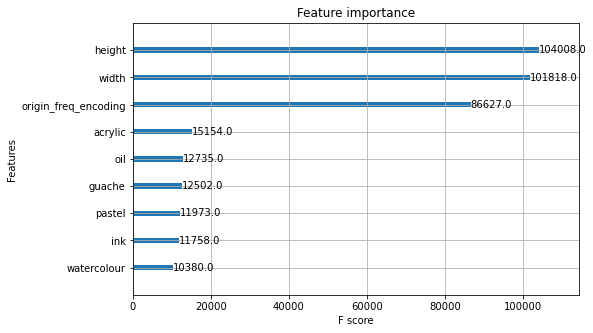

In [50]:
plt.figure(figsize=(8,5))
xgb.plot_importance(xg_model_methodical, ax=plt.gca())

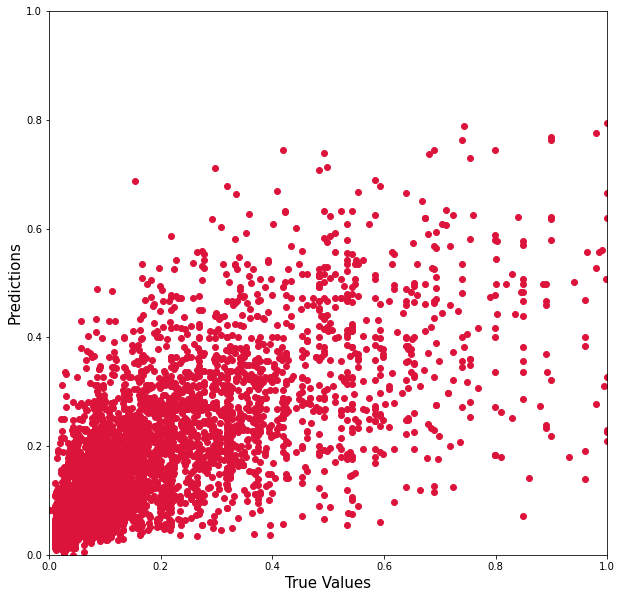

In [54]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_xg_model_methodical, c='crimson')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

### XGB Conclusion

We will use the methodical XGBoost as it achieved the best results on the validation set.

In [59]:
print('Default XGBoost')
print('R2  : ', r2_score(y_test, y_pred_xg_model_1))
print('MSE : ', mean_squared_error(y_test, y_pred_xg_model_1))

print('Grid search XGBoost')
print('R2  : ', r2_score(y_test, y_pred_xg_model_gs))
print('MSE : ', mean_squared_error(y_test, y_pred_xg_model_gs))

print('Methodical XGBoost')
print('R2  : ', r2_score(y_test, y_pred_xg_model_methodical))
print('MSE : ', mean_squared_error(y_test, y_pred_xg_model_methodical))

Default XGBoost
R2  :  0.5419339156047166
MSE :  0.013850609482607145
Grid search XGBoost
R2  :  0.5516111500201621
MSE :  0.013557997566278677
Methodical XGBoost
R2  :  0.5572583242522012
MSE :  0.013387243154125518
